In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

In [3]:
def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

## Problem 1

In [4]:
# Parameters
a1, a2 = 0, 0
b1, b2 = 0.02, 0.9
s1, s2 = 2., 1.5
mu = 0.002
k = 0.000025
g = 30.
c = 0.007
B1, B2 = 14, 1
A1, A2 = 250000, 75
T0, V0 = 400, 3
tf = 50
n = 1000

In [5]:
# initialize global variables, state, costate, and u.
state = np.zeros((n,2))
state0 = np.array([T0, V0])

costate = np.zeros((n,2))
costate0 = np.zeros(2)

u = np.zeros((n,2))
u[:,0] += .02
u[:,1] += .9

In [6]:
# define state equations
def state_equations(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the T cell concentration and the Virus concentration at time t
    i : int
        index for the global variable u.
    
    Returns
    --------------
    y_dot : ndarray (2,)
        the derivative of the T cell concentration and the virus concentration at time t
    '''
    # Define notation locally
    T = y[0]
    V = y[1]
    u1 = u[i,0]
    u2 = u[i,1]
    
    # return the function defining the dynamic system
    return np.array([s1 - ((s2*V)/(B1 + V)) - mu*T - k*V*T + u1*T, 
                       g*V*(1 - u2)/(B2 + V) - c*V*T])

In [7]:
print(RK4(state_equations, state0, 0, tf, n))

[[4.00000000e+02 3.00000000e+00]
 [4.00446527e+02 2.71118869e+00]
 [4.00894611e+02 2.45703339e+00]
 ...
 [1.14309199e+03 8.07050046e-46]
 [1.14422241e+03 6.28204218e-46]
 [1.14535385e+03 4.88797740e-46]]


## Problem 2

In [8]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the lambda_hat values at time t
    i : int
        index for global variables, u and state.
        
    Returns
    --------------
    y_dot : ndarray (2,)
        the derivative of the lambda_hats at time t.
    '''
    # Define notation locally
    lmbda1 = y[0]
    lmbda2 = y[1]
    T = state[n-1-i,0]
    V = state[n-1-i,1]
    u1 = u[n-1-i,0]
    u2 = u[n-1-i,1]
    
    # return the derivative of lambda hat
    return np.array([lmbda1*(-mu - k*V + u1) - c*lmbda2*V - 1, 
                     -lmbda1*(s2*B2/((B1 + V)**2) + k*T) + lmbda2*(g*B2*(1 - u2)/((B2 + V)**2) - c*T)])

In [10]:
print(RK4(lambda_hat,costate0,0,tf,n))

[[ 0.00000000e+00  0.00000000e+00]
 [-5.00726019e-02  1.00862381e-05]
 [-1.00190335e-01  4.25099166e-05]
 ...
 [-8.08430769e+01  8.82504183e+61]
 [-8.09660139e+01  1.02547697e+62]
 [-8.10890617e+01  1.19161249e+62]]


## Problem 3

In [12]:
epsilon = 0.001
test = epsilon + 1

while(test > epsilon):
    oldu = u.copy()
    
    #solve the state equations with forward iteration
    state = RK4(state_equations,state0,0,tf,n)
    
    #solve the costate equations with backwards iteration
    costate = RK4(lambda_hat,costate0,0,tf,n)[::-1]
    
    #solve for u1 and u2
    Tstar = state[:,0]
    Vstar = state[:,1]
    lmbda1 = costate[:,0]
    lmbda2 = costate[:,1]
    one_s = np.ones(lmbda1.shape[0])
    u1 = np.minimum(one_s*b1,np.maximum(one_s*a1,(-.5/A1)*lmbda1*Tstar))
    u2 = np.minimum(one_s*b2,np.maximum(one_s*a2,(lmbda2/(2*A2))*(g*Vstar/(B2+Vstar))))
    
    #update control
    u[:,0] = 0.5*(u1 + oldu[:,0])
    u[:,1] = 0.5*(u2 + oldu[:,1])
    
    #test for convergence
    test = abs(oldu - u).sum()

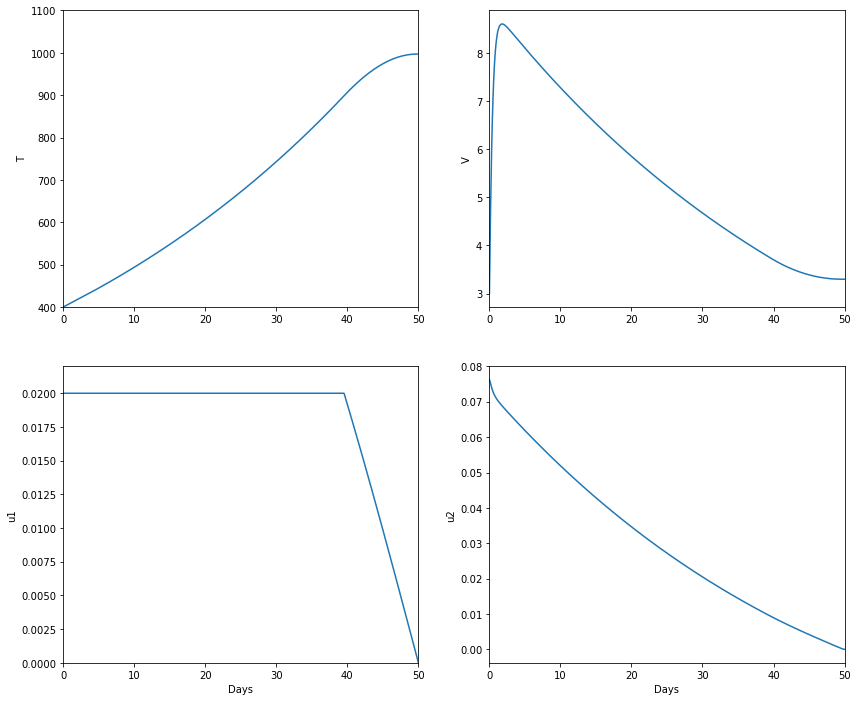

In [13]:
# Plot the graphs
plt.figure(figsize=(14,12))
time = np.linspace(0,50,state.shape[0])

plt.subplot(221)
plt.ylim(400,1100)
plt.xlim(0,50)
plt.ylabel('T')
plt.plot(time,state[:,0])

plt.subplot(222)
plt.xlim(0,50)
plt.ylabel("V")
plt.plot(time,state[:,1])

plt.subplot(223)
plt.ylim(0,0.022)
plt.xlim(0,50)
plt.ylabel('u1')
plt.xlabel('Days')
plt.plot(time,u[:,0])

plt.subplot(224)
plt.xlim(0,50)
plt.ylabel('u2')
plt.xlabel('Days')
plt.plot(time,u[:,1])

plt.show()